In [1]:
import pandas as pd
from freesurfer_stats import CorticalParcellationStats
import glob
import re
import itertools
import numpy as np
import pyls
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pickle
from sklearn import preprocessing
from scipy.stats import zscore
from nilearn import input_data
from nilearn import plotting
import pingouin as pg

/opt/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
sns.set_context("notebook", font_scale=1.7)
sns.set_style("whitegrid")

## Carga datos volúmenes

In [3]:
all_volumes_file = 'data/all_volumes.csv'
all_volumes = pd.read_csv(all_volumes_file)
all_volumes.drop(columns=all_volumes.columns[0], axis=1, inplace=True)
#all_volumes.columns.to_list()

# Selección de estructuras, no se inlcluye el 5to ventrículo
columns = list(range(0,15)) + list(range(21,54)) + list(range(61,467))
selected_values_vol = all_volumes.iloc[:,columns]

# Cambio nombre grupo
selected_values_vol.rename(columns={'grupo': 'group'}, inplace=True)

selected_values_vol.loc[selected_values_vol.subject.str.contains('CTRL'), 'group'] = 'CTRL'

# Selección prisma 1
selected_values_vol = selected_values_vol.loc[selected_values_vol['project'].isin(['prisma1','controles'])]

# Selección TAB y CTRL
selected_values_vol = selected_values_vol.loc[selected_values_vol['group'].isin(['TAB','CTRL'])]


/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/1139899660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_values_vol.rename(columns={'grupo': 'group'}, inplace=True)


In [4]:
# Conteo datos iniciales
#selected_values_vol.groupby('group').describe()

In [5]:
# Selección sujetos chequeo freesurfer
check_file = 'data/ConsolidadoRatings.xlsx'
check_data = pd.read_excel(check_file,'ALL')
suj_to_remove = check_data[check_data['Rating'] == 'FaIL'].Codigo

selected_values_vol = selected_values_vol.set_index('subject')
selected_values_vol.drop(index=suj_to_remove,inplace=True)
selected_values_vol = selected_values_vol.reset_index(drop=False)
selected_values_vol.groupby('group').describe()

Brain Segmentation Volume                                         \
                          count          mean            std       min   
group                                                                    
CTRL                       32.0  1.105633e+06  113994.378721  923026.0   
TAB                        66.0  1.067572e+06  119389.639898  850640.0   

                                                    \
             25%        50%         75%        max   
group                                                
CTRL   1042351.5  1083722.5  1137592.50  1497849.0   
TAB     974377.5  1051649.0  1154686.75  1324372.0   

      Brain Segmentation Volume Without Ventricles                ...  \
                                             count          mean  ...   
group                                                             ...   
CTRL                                          32.0  1.087699e+06  ...   
TAB                                           66.0  1.043146e+06  ...   

      17Networks_RH_TempPar_9         17Networks_RH_TempPar_10             \
                          75%     max                    count       mean   
group                                                                       
CTRL                   765.75  1491.0                     32.0  887.96875   
TAB                    760.50  1467.0                     66.0  860.69697   

                                                        
              std    min     25%    50%    75%     max  
group                                                   
CTRL   184.815424  549.0  786.50  896.0  971.5  1375.0  
TAB    171.937643  549.0  735.75  841.0  967.0  1333.0  

[2 rows x 3608 columns]

## Normalización por volumen intracraneal

In [6]:
selected_values_vol.iloc[:,3:] = selected_values_vol.iloc[:,3:].div(selected_values_vol["Estimated Total Intracranial Volume"], axis=0)

In [7]:
# Remover columna de ETIV
selected_values_vol = selected_values_vol.drop(['Estimated Total Intracranial Volume'],axis=1)


In [8]:
#selected_values_vol.head()

## Carga datos funcionales

In [9]:
func_file = 'data/functional_strength_data_acq_short.csv'
func_data = pd.read_csv(func_file)
func_data.drop(columns=func_data.columns[0], axis=1, inplace=True)

# Selección prisma 1
selected_values_func = func_data.loc[func_data['project'].isin(['prisma1','controles'])]

# Selección TAB y CTRL
selected_values_func = selected_values_func.loc[selected_values_func['group'].isin(['TAB','CTRL'])]

In [10]:
# Conteo datos iniciales
selected_values_func.groupby('group').describe()

7Networks_LH_Vis_1                                                       \
                   count       mean        std       min       25%        50%   
group                                                                           
CTRL                32.0  14.363881  10.932302  0.404651  4.890052  11.858522   
TAB                 39.0  19.070088  17.640826  0.532326  2.608257  15.122091   

                            7Networks_LH_Vis_2             ...  \
             75%        max              count       mean  ...   
group                                                      ...   
CTRL   23.547004  34.392861               32.0  11.488069  ...   
TAB    30.078793  87.754399               39.0  15.052220  ...   

      7Networks_Stra_Cont_6            7Networks_Stra_Default_7            \
                        75%        max                    count      mean   
group                                                                       
CTRL              12.555124  43.843471                     32.0  9.938004   
TAB               15.799214  49.886436                     39.0  7.714503   

                                                                 
             std  min       25%       50%        75%        max  
group                                                            
CTRL   11.485387  0.0  3.047059  7.359538  12.147215  61.409917  
TAB     5.863122  0.0  2.939112  6.438915  10.653762  20.862550  

[2 rows x 3080 columns]

In [11]:
#selected_values_func.head()

## Carga de datos clínicos

In [12]:
clinical_file = 'data/BFCN_t1_cov.xlsx'
clinical_data = pd.read_excel(clinical_file)
clinical_data.loc[clinical_data.subject.str.contains('CTRL'), 'project'] = 'controles'
# Selección de variables
clinical_data.drop(columns=['group','columna1','dim3','dim4','id_prisma'],inplace=True)
#clinical_data

## Merge all files

In [13]:
# Unión archivos volúmenes, funcionales e información clínica
clinical_image_df= pd.merge(pd.merge(selected_values_vol, selected_values_func, how='inner', on=['subject', 'project','group']), 
                           clinical_data, how='left', on=['subject', 'project'])
clinical_image_df.groupby('group').describe()

Brain Segmentation Volume                                          \
                          count      mean       std       min       25%   
group                                                                     
CTRL                       25.0  0.833085  0.035770  0.780324  0.806800   
TAB                        31.0  0.808028  0.036464  0.756481  0.779943   

                                     \
            50%       75%       max   
group                                 
CTRL   0.828134  0.847668  0.920915   
TAB    0.803665  0.817552  0.899731   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTRL                                          25.0  0.819541  ...   
TAB                                           31.0  0.791979  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTRL            NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 7696 columns]

In [14]:
#Remove data for TAB and diagnosis 2
clinical_image_df.drop(clinical_image_df.index[clinical_image_df['diagnosis']=='Bipolar Affective Disorder 2'],inplace=True)
clinical_image_df.groupby('group').describe()

Brain Segmentation Volume                                          \
                          count      mean       std       min       25%   
group                                                                     
CTRL                       25.0  0.833085  0.035770  0.780324  0.806800   
TAB                        30.0  0.806295  0.035766  0.756481  0.778895   

                                     \
            50%       75%       max   
group                                 
CTRL   0.828134  0.847668  0.920915   
TAB    0.803626  0.817299  0.899731   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTRL                                          25.0  0.819541  ...   
TAB                                           30.0  0.790069  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTRL            NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 7696 columns]

## Normalización por sujeto

In [15]:
# Normalización z-score por fila (sujeto) para datos de volumen 3 a 454
clinical_image_z = clinical_image_df
clinical_image_z.iloc[:,3:453] = clinical_image_z.iloc[:,3:453].apply(zscore, axis=1) 
clinical_image_z.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTRL                       25.0  11.197206  0.080392  11.056882  11.142646   
TAB                        30.0  11.260625  0.077924  11.109363  11.211153   

                                        \
             50%        75%        max   
group                                    
CTRL   11.194166  11.239603  11.376816   
TAB    11.251043  11.300246  11.424752   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTRL                                          25.0  11.010927  ...   
TAB                                           30.0  11.029037  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTRL            NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 7696 columns]

In [16]:
# Normalización z-score por fila (sujeto) para datos de conectividad 453 a 838
clinical_image_z.iloc[:,453:838] = clinical_image_z.iloc[:,453:838].apply(zscore, axis=1) 
clinical_image_z.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTRL                       25.0  11.197206  0.080392  11.056882  11.142646   
TAB                        30.0  11.260625  0.077924  11.109363  11.211153   

                                        \
             50%        75%        max   
group                                    
CTRL   11.194166  11.239603  11.376816   
TAB    11.251043  11.300246  11.424752   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTRL                                          25.0  11.010927  ...   
TAB                                           30.0  11.029037  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTRL            NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 7696 columns]

In [17]:
#clinical_image_z.iloc[:,453:].columns.to_list()

In [18]:
# Selección variables clínicas para regresión datos volumen
list_regression = ['age','sex','education_level','etiv',
                   'antipsychotic_use','antidepressant_use','moodstabiliser_use']
list_norm = ['age','education_level','etiv']

In [19]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z.dropna(subset = list_regression)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

Brain Segmentation Volume                                             \
                          count       mean       std        min        25%   
group                                                                        
CTRL                       25.0  11.197206  0.080392  11.056882  11.142646   
TAB                        30.0  11.260625  0.077924  11.109363  11.211153   

                                        \
             50%        75%        max   
group                                    
CTRL   11.194166  11.239603  11.376816   
TAB    11.251043  11.300246  11.424752   

      Brain Segmentation Volume Without Ventricles             ...  \
                                             count       mean  ...   
group                                                          ...   
CTRL                                          25.0  11.010927  ...   
TAB                                           30.0  11.029037  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTRL            NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 7696 columns]

In [20]:
# Normalización covariables por columna
clinical_image_z_na[list_norm] = clinical_image_z_na[list_norm].apply(zscore, axis=0)

## Regresión lineal múltiple volúmenes

In [21]:
vol_cols = clinical_image_z_na.iloc[:,3:453].columns.to_list()
residuals = pd.DataFrame()

for col in vol_cols:
    lm = pg.linear_regression(clinical_image_z_na[list_regression]
                              ,clinical_image_z_na[col])
    
    residuals[col] = lm.residuals_

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/804178210.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [22]:
# Formación nuevo data frame
clinical_image_z_na.iloc[:,3:453] = residuals.values

In [23]:
#clinical_image_z.iloc[:,453:].columns.to_list()

## Regresión lineal múltiple datos funcionales

In [24]:
# Selección variables clínicas
list_regression = ['age','sex','education_level','fdmean_short',
                   'antipsychotic_use','antidepressant_use','moodstabiliser_use']
list_norm = ['fdmean_short']

In [25]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z_na.dropna(subset = list_norm)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

Brain Segmentation Volume                                          \
                          count      mean       std       min       25%   
group                                                                     
CTRL                       25.0 -0.004298  0.068195 -0.136022 -0.047319   
TAB                        30.0  0.003582  0.069445 -0.096083 -0.055322   

                                     \
            50%       75%       max   
group                                 
CTRL  -0.006167  0.029803  0.157147   
TAB    0.001517  0.041724  0.206939   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTRL                                          25.0 -0.003783  ...   
TAB                                           30.0  0.003153  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTRL            NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 7696 columns]

In [26]:
clinical_image_z_na[list_norm] = clinical_image_z_na[list_norm].apply(zscore, axis=0)

In [27]:
func_cols = clinical_image_z_na.iloc[:,453:838].columns.to_list()
residuals = pd.DataFrame()

for col in func_cols:
    lm = pg.linear_regression(clinical_image_z_na[list_regression]
                              ,clinical_image_z_na[col])
    
    residuals[col] = lm.residuals_

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_5472/3835837914.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [28]:
# Formación nuevo data frame
clinical_image_z_na.iloc[:,453:838] = residuals.values

## Regresión lineal múltiple datos psicológicos

In [29]:
# Selección variables psycológicas que se encuentran para TAB y CTRL (continuas)
y_list = ['psy_cit','psy_tmt_a','psy_tmt_b',
          'psy_tavec_1_en_a','psy_tavec_a_5_ens','psy_tavec_rec_tl_a','psy_tavec_b_in','psy_tavec_%_pri',
          'psy_tavec_%_med','psy_tavec_%_rec','psy_tavec_re_lb_cp','psy_tavec_re_lb_lp','psy_tavec_re_cl_cp',
          'psy_tavec_re_cl_lp','psy_tavec_est_ser_a','psy_tavec_est_ser_rcp',
          'psy_tavec_est_ser_rlp','psy_tavec_est_sem_a','psy_tavec_est_sem_b','psy_tavec_rec','psy_wmsiii_d',
          'psy_wmsiii_i','psy_fas_sm','psy_fas_fn','psy_wcst_err','psy_wcst_cat','psy_wcst_%pers','psy_wcst_%conc']

In [30]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z_na.dropna(subset = y_list)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

Brain Segmentation Volume                                          \
                          count      mean       std       min       25%   
group                                                                     
CTRL                       20.0 -0.008030  0.072394 -0.136022 -0.047642   
TAB                        20.0  0.001382  0.074334 -0.096083 -0.057411   

                                     \
            50%       75%       max   
group                                 
CTRL  -0.013720  0.020309  0.157147   
TAB   -0.003127  0.020755  0.206939   

      Brain Segmentation Volume Without Ventricles            ...  \
                                             count      mean  ...   
group                                                         ...   
CTRL                                          20.0 -0.016095  ...   
TAB                                           20.0  0.002593  ...   

      psy_cpt_pun_t     psy_cpt_pun_t2                               
                75% max          count mean std min 25% 50% 75% max  
group                                                                
CTRL            NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB             NaN NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 7696 columns]

In [31]:
# Normalización variables psicológicas por columna
clinical_image_z_na[y_list] = clinical_image_z_na[y_list].apply(zscore, axis=0)

In [32]:
list_regression_psy = ['age','sex','education_level','antipsychotic_use','antidepressant_use','moodstabiliser_use']

psy_cols = clinical_image_z_na[y_list].columns.to_list()

residuals_psy = pd.DataFrame()

for col in psy_cols:
    lm = pg.linear_regression(clinical_image_z_na[list_regression_psy]
                              ,clinical_image_z_na[col])
    
    residuals_psy[col] = lm.residuals_



In [33]:
# Reemplazo de los valores de las pruebas por los residuos
clinical_image_z_na[y_list] = residuals_psy.values

## PLS BEHAVIORAL

In [34]:
all_data_sorted = clinical_image_z_na.sort_values('group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups = all_data_sorted.groupby(['group']).count()
groups_dict = count_groups['subject'].to_dict()

list_len = list(groups_dict.values())
groups = list(groups_dict.keys())
groups_dict

{'CTRL': 20, 'TAB': 20}

In [35]:
# Matriz X: datos de volúmenes + func
X_brain = all_data_sorted.iloc[:,3:838].values
X_brain.shape

(40, 835)

In [36]:
# Matriz Y: datos neuropsicológicos
Y_beha = all_data_sorted[y_list].values
Y_beha.shape

(40, 28)

In [37]:
pls = pyls.behavioral_pls(X_brain, Y_beha, groups=list_len, seed=42, n_proc='max')

Running permutations:   0%|                                   | 0/5000 | 00:00<?/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:   0%|                              | 16/5000 | 00:01<06:09nt your code to be deterministic or not. FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running permutations:   1%|4                             | 72/5000 | 00:01<01:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:   5%|#5                           | 264/5000 | 00:01<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  16%|####5                        | 776/5000 | 00:01<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  23%|######4                     | 1160/5000 | 00:02<00:04lt is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  26%|#######2                    | 1288/5000 | 00:02<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  31%|########6                   | 1544/5000 | 00:02<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  33%|#########3                  | 1672/5000 | 00:02<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  39%|##########7                 | 1928/5000 | 00:03<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  41%|###########5                | 2056/5000 | 00:03<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  46%|############9               | 2312/5000 | 00:03<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  51%|##############3             | 2568/5000 | 00:04<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  69%|###################3        | 3464/5000 | 00:05<00:01nt your code to be deterministic or not. FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  72%|####################1       | 3592/5000 | 00:05<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  82%|######################9     | 4104/5000 | 00:06<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  87%|########################4   | 4360/5000 | 00:06<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  92%|#########################8  | 4616/5000 | 00:06<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   4%|#                              | 176/5000 | 00:02<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#1                             | 192/5000 | 00:02<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#2                             | 208/5000 | 00:02<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#3                             | 224/5000 | 00:02<01:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   5%|#6                             | 264/5000 | 00:03<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   6%|#8                             | 296/5000 | 00:03<01:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:   6%|#9                             | 320/5000 | 00:04<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   7%|##                             | 336/5000 | 00:04<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   7%|##1                            | 352/5000 | 00:04<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   8%|##4                            | 392/5000 | 00:05<00:59/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##5                            | 408/5000 | 00:05<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##6                            | 424/5000 | 00:05<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  10%|###                            | 496/5000 | 00:06<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  10%|###1                           | 512/5000 | 00:06<00:59/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###2                           | 528/5000 | 00:07<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  12%|###6                           | 592/5000 | 00:07<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  12%|###7                           | 608/5000 | 00:07<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  12%|###8                           | 624/5000 | 00:08<00:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|###9                           | 640/5000 | 00:08<00:53/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|####                           | 656/5000 | 00:08<00:53/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|####1                          | 672/5000 | 00:08<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  14%|####2                          | 688/5000 | 00:09<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  14%|####3                          | 704/5000 | 00:09<00:57/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  14%|####4                          | 720/5000 | 00:09<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  15%|####5                          | 736/5000 | 00:09<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  15%|####6                          | 752/5000 | 00:09<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  16%|####9                          | 792/5000 | 00:10<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  16%|#####                          | 808/5000 | 00:10<01:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  16%|#####1                         | 824/5000 | 00:10<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####2                         | 840/5000 | 00:11<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####3                         | 856/5000 | 00:11<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####4                         | 872/5000 | 00:11<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  18%|#####5                         | 888/5000 | 00:11<00:53/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  19%|######                         | 968/5000 | 00:12<00:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  20%|######1                        | 984/5000 | 00:13<00:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  20%|######                        | 1000/5000 | 00:13<00:52/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  20%|######                        | 1016/5000 | 00:13<00:51/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  21%|######1                       | 1032/5000 | 00:13<00:49/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  21%|######3                       | 1064/5000 | 00:14<00:52/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  22%|######4                       | 1080/5000 | 00:14<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  22%|######5                       | 1096/5000 | 00:14<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  23%|######7                       | 1128/5000 | 00:15<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  23%|######9                       | 1160/5000 | 00:15<00:53/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######                       | 1176/5000 | 00:15<00:54/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######1                      | 1192/5000 | 00:15<00:51/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  24%|#######2                      | 1216/5000 | 00:16<00:48/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  25%|#######3                      | 1232/5000 | 00:16<00:49/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  25%|#######5                      | 1264/5000 | 00:16<00:50/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######6                      | 1280/5000 | 00:17<00:49/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######7                      | 1296/5000 | 00:17<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######8                      | 1312/5000 | 00:17<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|#######9                      | 1328/5000 | 00:17<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########                      | 1344/5000 | 00:17<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########1                     | 1360/5000 | 00:18<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########2                     | 1376/5000 | 00:18<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########3                     | 1392/5000 | 00:18<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########4                     | 1408/5000 | 00:18<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########5                     | 1424/5000 | 00:18<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########6                     | 1440/5000 | 00:19<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########7                     | 1456/5000 | 00:19<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########8                     | 1472/5000 | 00:19<00:51/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|########9                     | 1488/5000 | 00:19<00:48/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|#########                     | 1504/5000 | 00:20<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|#########1                    | 1520/5000 | 00:20<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########2                    | 1536/5000 | 00:20<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########3                    | 1552/5000 | 00:20<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########4                    | 1568/5000 | 00:20<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########5                    | 1584/5000 | 00:21<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########6                    | 1600/5000 | 00:21<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########6                    | 1616/5000 | 00:21<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|#########7                    | 1632/5000 | 00:21<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|#########8                    | 1648/5000 | 00:21<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|#########9                    | 1664/5000 | 00:22<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  34%|##########                    | 1680/5000 | 00:22<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  34%|##########1                   | 1696/5000 | 00:22<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  34%|##########2                   | 1712/5000 | 00:22<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########3                   | 1728/5000 | 00:22<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########4                   | 1744/5000 | 00:23<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########5                   | 1760/5000 | 00:23<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########6                   | 1776/5000 | 00:23<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########7                   | 1792/5000 | 00:23<00:42/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########8                   | 1808/5000 | 00:24<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########9                   | 1824/5000 | 00:24<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  37%|###########                   | 1840/5000 | 00:24<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  37%|###########1                  | 1856/5000 | 00:24<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  40%|############                  | 2008/5000 | 00:26<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|############1                 | 2024/5000 | 00:26<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############2                 | 2040/5000 | 00:26<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############3                 | 2056/5000 | 00:27<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############4                 | 2072/5000 | 00:27<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############5                 | 2088/5000 | 00:27<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############6                 | 2104/5000 | 00:27<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  43%|#############                 | 2168/5000 | 00:28<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############1                | 2184/5000 | 00:28<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############2                | 2200/5000 | 00:29<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############2                | 2216/5000 | 00:29<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  45%|#############3                | 2232/5000 | 00:29<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  45%|#############4                | 2248/5000 | 00:29<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  46%|#############8                | 2304/5000 | 00:30<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  46%|#############9                | 2320/5000 | 00:30<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  47%|##############                | 2336/5000 | 00:30<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  47%|##############1               | 2352/5000 | 00:31<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  48%|##############4               | 2400/5000 | 00:31<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  49%|##############7               | 2456/5000 | 00:32<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  49%|##############8               | 2472/5000 | 00:32<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  50%|##############9               | 2488/5000 | 00:32<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  50%|###############               | 2504/5000 | 00:33<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  50%|###############1              | 2520/5000 | 00:33<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  51%|###############2              | 2536/5000 | 00:33<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  51%|###############4              | 2568/5000 | 00:34<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############5              | 2584/5000 | 00:34<00:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############6              | 2600/5000 | 00:34<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############6              | 2616/5000 | 00:34<00:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  53%|###############7              | 2632/5000 | 00:34<00:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  55%|################5             | 2752/5000 | 00:36<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  55%|################6             | 2768/5000 | 00:36<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################7             | 2784/5000 | 00:36<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################8             | 2800/5000 | 00:36<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################8             | 2816/5000 | 00:37<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  57%|################9             | 2832/5000 | 00:37<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  57%|#################             | 2848/5000 | 00:37<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  57%|#################1            | 2864/5000 | 00:37<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  58%|#################2            | 2880/5000 | 00:38<00:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  58%|#################3            | 2896/5000 | 00:38<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  59%|#################5            | 2928/5000 | 00:38<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  59%|#################6            | 2944/5000 | 00:38<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  59%|#################7            | 2960/5000 | 00:39<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  60%|#################8            | 2976/5000 | 00:39<00:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  60%|#################9            | 2992/5000 | 00:39<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  61%|##################2           | 3040/5000 | 00:40<00:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################3           | 3056/5000 | 00:40<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################4           | 3072/5000 | 00:40<00:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  62%|##################5           | 3088/5000 | 00:40<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  64%|###################3          | 3224/5000 | 00:42<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  65%|###################4          | 3240/5000 | 00:42<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  65%|###################5          | 3256/5000 | 00:42<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  65%|###################6          | 3272/5000 | 00:43<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  66%|###################7          | 3288/5000 | 00:43<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  66%|###################8          | 3304/5000 | 00:43<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  66%|###################9          | 3320/5000 | 00:43<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  67%|####################          | 3336/5000 | 00:43<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  68%|####################4         | 3408/5000 | 00:44<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  68%|####################5         | 3424/5000 | 00:45<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  69%|####################7         | 3456/5000 | 00:45<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  70%|####################9         | 3496/5000 | 00:46<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  70%|#####################         | 3512/5000 | 00:46<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################1        | 3528/5000 | 00:46<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################2        | 3544/5000 | 00:46<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################3        | 3560/5000 | 00:46<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  72%|#####################6        | 3608/5000 | 00:47<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  72%|#####################7        | 3624/5000 | 00:47<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  73%|#####################8        | 3640/5000 | 00:47<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  73%|#####################9        | 3656/5000 | 00:48<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  73%|######################        | 3672/5000 | 00:48<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  75%|######################3       | 3728/5000 | 00:49<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################4       | 3744/5000 | 00:49<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################5       | 3760/5000 | 00:49<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################6       | 3776/5000 | 00:49<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################7       | 3792/5000 | 00:49<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################8       | 3808/5000 | 00:50<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################9       | 3824/5000 | 00:50<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  78%|#######################3      | 3896/5000 | 00:51<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  78%|#######################4      | 3912/5000 | 00:51<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################5      | 3928/5000 | 00:51<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################6      | 3944/5000 | 00:52<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################7      | 3960/5000 | 00:52<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|#######################8      | 3976/5000 | 00:52<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  80%|########################      | 4016/5000 | 00:53<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################1     | 4032/5000 | 00:53<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################2     | 4048/5000 | 00:53<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################3     | 4064/5000 | 00:53<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################4     | 4080/5000 | 00:54<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################5     | 4096/5000 | 00:54<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################6     | 4112/5000 | 00:54<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  83%|########################7     | 4128/5000 | 00:54<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  83%|########################8     | 4144/5000 | 00:54<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  83%|########################9     | 4160/5000 | 00:55<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  85%|#########################5    | 4264/5000 | 00:56<00:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  86%|#########################8    | 4304/5000 | 00:56<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  86%|#########################9    | 4320/5000 | 00:57<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  88%|##########################2   | 4376/5000 | 00:57<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################3   | 4392/5000 | 00:58<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################4   | 4408/5000 | 00:58<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################5   | 4424/5000 | 00:58<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################6   | 4440/5000 | 00:58<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################7   | 4456/5000 | 00:58<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################8   | 4472/5000 | 00:59<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|##########################9   | 4488/5000 | 00:59<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|###########################   | 4504/5000 | 00:59<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  91%|###########################2  | 4536/5000 | 00:59<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  91%|###########################3  | 4552/5000 | 01:00<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  91%|###########################4  | 4568/5000 | 01:00<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################5  | 4584/5000 | 01:00<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################6  | 4600/5000 | 01:00<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################6  | 4616/5000 | 01:00<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################7  | 4632/5000 | 01:01<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################8  | 4648/5000 | 01:01<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################9  | 4664/5000 | 01:01<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################  | 4680/5000 | 01:01<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running bootstraps:  94%|############################3 | 4720/5000 | 01:02<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################4 | 4736/5000 | 01:02<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################5 | 4752/5000 | 01:02<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################6 | 4768/5000 | 01:03<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  96%|############################8 | 4800/5000 | 01:03<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################8 | 4816/5000 | 01:03<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  98%|#############################3| 4896/5000 | 01:04<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################4| 4912/5000 | 01:04<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  99%|#############################5| 4928/5000 | 01:05<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  99%|#############################7| 4960/5000 | 01:05<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps: 100%|#############################8| 4976/5000 | 01:05<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps: 100%|#############################9| 4992/5000 | 01:05<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

In [38]:
# Resultados PLS
pls.x_weights.shape

(835, 56)

In [39]:
pls.y_weights.shape

(56, 56)

In [40]:
pls.x_scores.shape

(40, 56)

In [41]:
pls.y_scores.shape

(40, 56)

In [42]:
pls.y_loadings.shape # correlación

(56, 56)

In [43]:
# Significancia PLS 
pvals = pls.permres['pvals']
x_weights = pls.bootres.x_weights_normed 

In [44]:
sig_ind = np.where(pvals < 0.05)[0]
sig_ind

array([0, 2, 4, 5, 6])

In [45]:
pls.varexp[sig_ind]

array([0.16939733, 0.1040149 , 0.06562182, 0.05936013, 0.05095966])

In [46]:
conditions = []
for j in y_list:
    conditions = conditions + [j + '-' + i for i in groups]
#conditions

[Text(0, 0, 'psy_cit-CTRL'),
 Text(0, 1, 'psy_cit-TAB'),
 Text(0, 2, 'psy_tmt_a-CTRL'),
 Text(0, 3, 'psy_tmt_a-TAB'),
 Text(0, 4, 'psy_tmt_b-CTRL'),
 Text(0, 5, 'psy_tmt_b-TAB'),
 Text(0, 6, 'psy_tavec_1_en_a-CTRL'),
 Text(0, 7, 'psy_tavec_1_en_a-TAB'),
 Text(0, 8, 'psy_tavec_a_5_ens-CTRL'),
 Text(0, 9, 'psy_tavec_a_5_ens-TAB'),
 Text(0, 10, 'psy_tavec_rec_tl_a-CTRL'),
 Text(0, 11, 'psy_tavec_rec_tl_a-TAB'),
 Text(0, 12, 'psy_tavec_b_in-CTRL'),
 Text(0, 13, 'psy_tavec_b_in-TAB'),
 Text(0, 14, 'psy_tavec_%_pri-CTRL'),
 Text(0, 15, 'psy_tavec_%_pri-TAB'),
 Text(0, 16, 'psy_tavec_%_med-CTRL'),
 Text(0, 17, 'psy_tavec_%_med-TAB'),
 Text(0, 18, 'psy_tavec_%_rec-CTRL'),
 Text(0, 19, 'psy_tavec_%_rec-TAB'),
 Text(0, 20, 'psy_tavec_re_lb_cp-CTRL'),
 Text(0, 21, 'psy_tavec_re_lb_cp-TAB'),
 Text(0, 22, 'psy_tavec_re_lb_lp-CTRL'),
 Text(0, 23, 'psy_tavec_re_lb_lp-TAB'),
 Text(0, 24, 'psy_tavec_re_cl_cp-CTRL'),
 Text(0, 25, 'psy_tavec_re_cl_cp-TAB'),
 Text(0, 26, 'psy_tavec_re_cl_lp-CTRL'),
 Text(

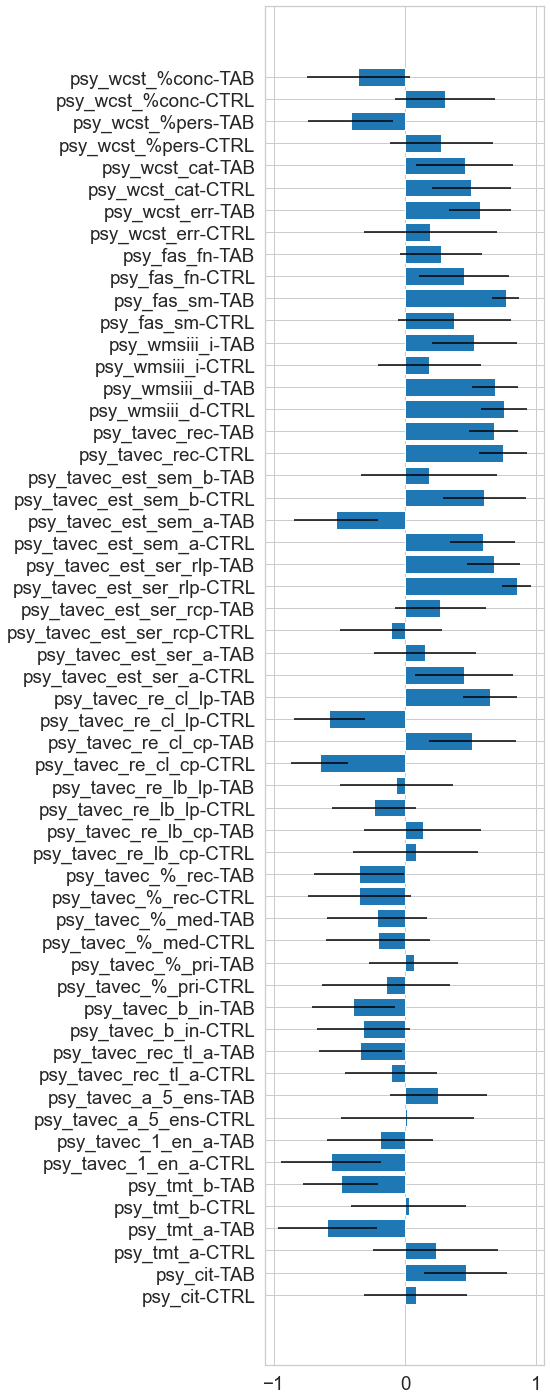

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(5,25))
icx = 0
err = (pls["bootres"]["y_loadings_ci"][:, icx, 1] - pls["bootres"]["y_loadings_ci"][:, icx, 0]) / 2   
axs.barh(np.arange(len(err)), pls["y_loadings"][:, icx], xerr=err)
axs.set_yticks(np.arange(len(conditions)))#, labels=ext_pet_roi_df.columns[1:].to_numpy()[relidx])
axs.set_yticklabels(np.array(conditions)) #(ext_pet_roi_maps.columns[1:].to_numpy()[sorted_idx])

In [48]:
# Búsqueda de índices que no pasen por cero
icx = 0 # Componente a graficar
ind_sig = np.where(abs(err) < abs(pls["y_loadings"][:, icx]))[0]

new_ind = list()
for i in range(len(ind_sig)):
    if ind_sig[i] % 2 == 0: # Si el índice es par
        if i==len(ind_sig)-1:
            new_ind.insert(i+1, ind_sig[i] + 1)
            
        elif ind_sig[i] + 1 == ind_sig[i+1]: # Si los dos índices son consecutivos 
            flag = 'ok'
        else:
            new_ind.insert(i+1, ind_sig[i] + 1) # Insertar consecutivo 
            flag = 'ok'
    else: # Si el índice es impar
        if i==0:
            new_ind.insert(0, ind_sig[i] - 1) # Insertar en la primera posición
            
        elif ind_sig[i] - 1 == ind_sig[i-1]:
            flag = 'ok'
        else:
            new_ind.insert(i-1, ind_sig[i] - 1)
            #print('no')
            
new_sig = list(ind_sig) + new_ind
new_sig.sort()

color_list = ['C0','C1']

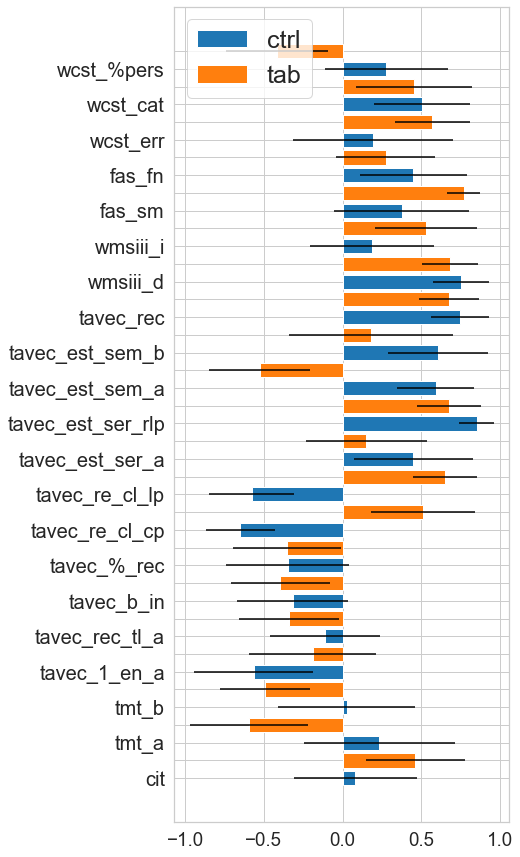

In [49]:
# Gráfico y loadings 
fig, axs = plt.subplots(1, 1, figsize=(6,15))
#sorted_idx = np.argsort(pls["y_loadings"][new_sig, icx])
err_sig = (pls["bootres"]["y_loadings_ci"][new_sig, icx, 1] - pls["bootres"]["y_loadings_ci"][new_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls["y_loadings"][new_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i.split('-')[0][4:] for i in conditions]
axs.set_yticks(np.arange(len(new_sig)))
labels = np.array(conditions_new)[new_sig]
labels[1::2] = ' '
axs.set_yticklabels(labels, fontsize = 20)
axs.legend(axx,['ctrl','tab'], fontsize = 25)


## Gráficos de dispersión

In [50]:
score_pls = pd.DataFrame()
score_pls['subject'] = all_data_sorted['subject']
score_pls['group'] = all_data_sorted['group']
score_pls['psy_tavec_re_cl_lp'] = all_data_sorted['psy_tavec_re_cl_lp']
score_pls['psy_tavec_re_cl_cp'] = all_data_sorted['psy_tavec_re_cl_cp']
score_pls['psy_tavec_est_sem_a'] = all_data_sorted['psy_tavec_est_sem_a']
score_pls['x_score']=pls.x_scores[:,icx]
score_pls['y_score']=pls.y_scores[:,icx]
score_pls['is_paisa']= all_data_sorted['is_paisa']
score_pls['t-t']= all_data_sorted['t-t']
score_pls['hsp']= all_data_sorted['hsp']
score_pls['active_psychosis'] = all_data_sorted['active_psychosis']
score_pls['psychotic_symptoms '] = all_data_sorted['psychotic_symptoms ']
score_pls['spa_abuse'] = all_data_sorted['spa_abuse']
score_pls['alcohol_abuse'] = all_data_sorted['alcohol_abuse']
score_pls['years_alcohol_abuse'] = all_data_sorted['years_alcohol_abuse']
score_pls['years_spa'] = all_data_sorted['years_spa']
score_pls = score_pls.reset_index(drop=True)

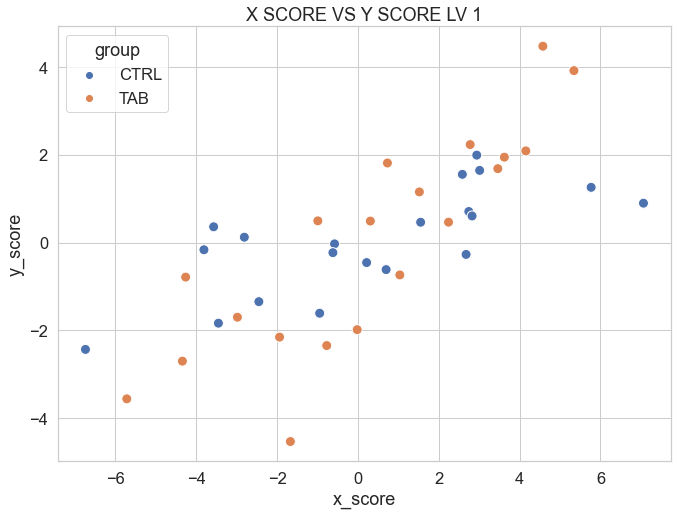

In [51]:
# Gráfico x vs y scores
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)

sns.scatterplot(x="x_score", y="y_score", hue="group",data=score_pls,linewidth=1, s=100)

plt.title("X SCORE VS Y SCORE LV 1")
plt.show()

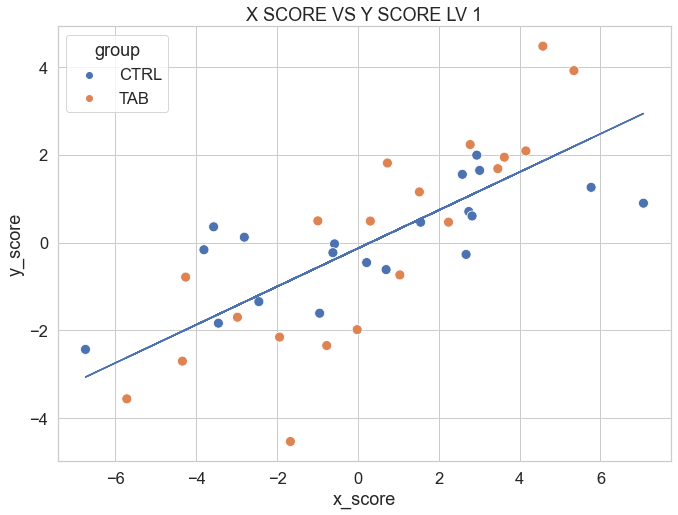

In [52]:
# Gráfico x vs y scores con regresión 
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.scatterplot(x="x_score", y="y_score",hue= 'group', data=score_pls, s=100)
x=score_pls["x_score"]
y=score_pls["y_score"]
m, b = np. polyfit(x, y, 1)
plt. plot(x, m*x + b) 
plt.title("X SCORE VS Y SCORE LV 1")
plt.show()

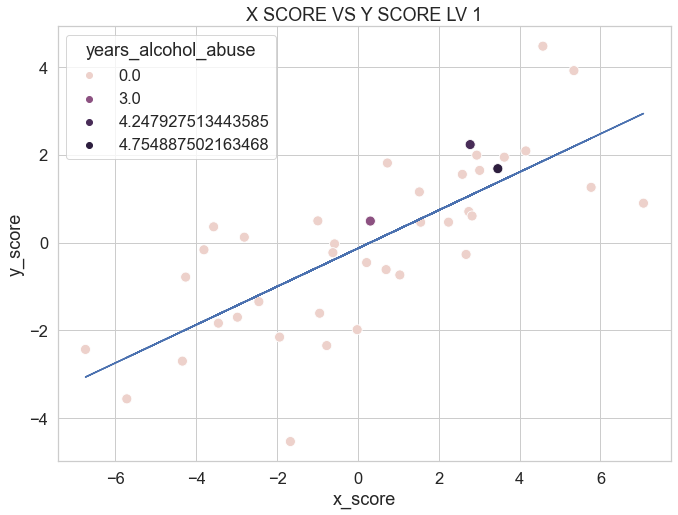

In [53]:
# Gráfico x vs y scores con regresión 
hue_var = 'years_alcohol_abuse'
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)

idx = np.where(score_pls[hue_var]>0)

score_pls.loc[idx[0],hue_var] = np.log2(score_pls[hue_var][idx[0]])

sns.scatterplot(x="x_score", y="y_score",hue= hue_var, data=score_pls, s=100)
x=score_pls["x_score"]
y=score_pls["y_score"]
m, b = np. polyfit(x, y, 1)
plt. plot(x, m*x + b) 
plt.title("X SCORE VS Y SCORE LV 1")
plt.show()

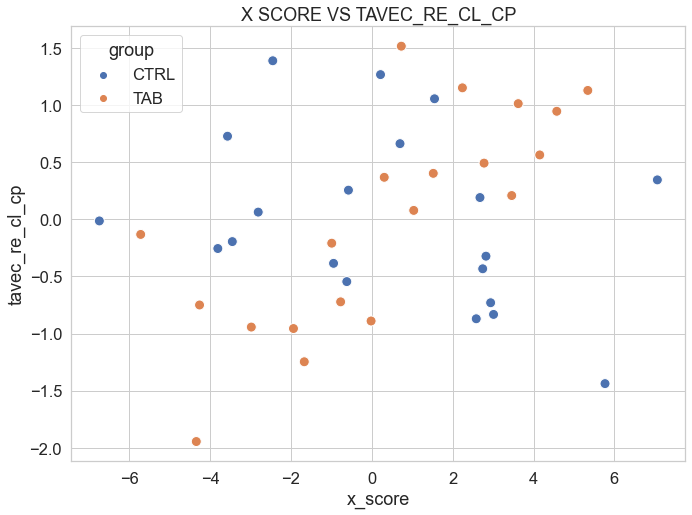

In [54]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_cp (recuerdo claves a corto plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)
        
g=sns.scatterplot(x="x_score", y="psy_tavec_re_cl_cp", s=100,
                  hue="group",legend=True,data=score_pls,linewidth=1)

plt.title("X SCORE VS TAVEC_RE_CL_CP")
plt.ylabel('tavec_re_cl_cp')
plt.show()

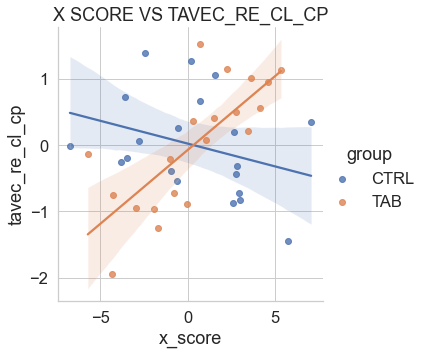

In [55]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_cp (recuerdo claves a corto plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="x_score", y="psy_tavec_re_cl_cp",
                  hue="group", data=score_pls)

plt.title("X SCORE VS TAVEC_RE_CL_CP")
plt.ylabel('tavec_re_cl_cp')
plt.show()

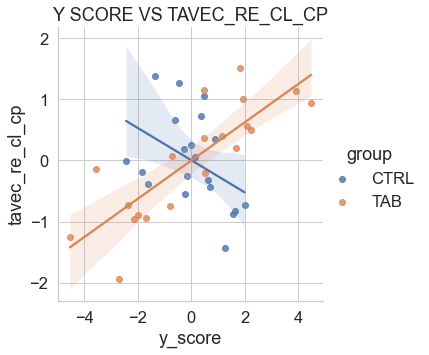

In [56]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_cp (recuerdo claves a corto plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="y_score", y="psy_tavec_re_cl_cp"º,
                  hue="group", data=score_pls)

plt.title("Y SCORE VS TAVEC_RE_CL_CP")
plt.ylabel('tavec_re_cl_cp')
plt.show()

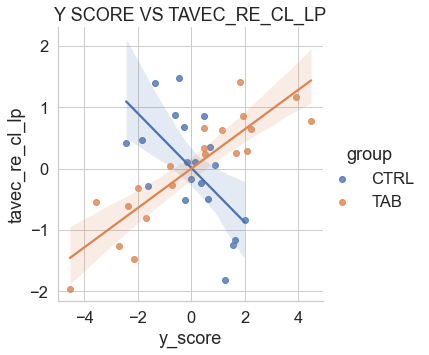

In [57]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_lp (recuerdo claves a largo plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="y_score", y="psy_tavec_re_cl_lp", hue="group", data=score_pls)

plt.title("Y SCORE VS TAVEC_RE_CL_LP")
plt.ylabel('tavec_re_cl_lp')
plt.show()

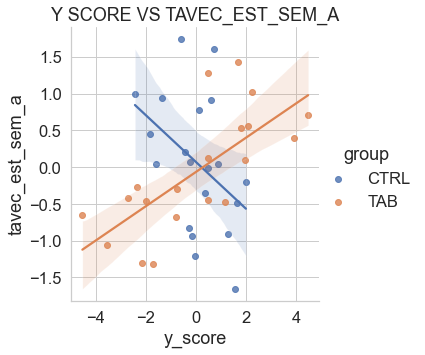

In [58]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_lp (recuerdo claves a largo plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="y_score", y="psy_tavec_est_sem_a", hue="group", data=score_pls)

plt.title("Y SCORE VS TAVEC_EST_SEM_A")
plt.ylabel('tavec_est_sem_a')
plt.show()

## Gráficos x-weights

In [59]:
import nibabel as nib

yeo_palett = {'Vis': (0.47058823529411764, 0.07058823529411765, 0.5254901960784314),
 'SomMot': (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
 'DorsAttn': (0.0, 0.4627450980392157, 0.054901960784313725),
 'SalVentAttn': (0.7686274509803922, 0.22745098039215686, 0.9803921568627451),
 'Limbic': (0.8627450980392157, 0.9725490196078431, 0.6431372549019608),
 'Cont': (0.9019607843137255, 0.5803921568627451, 0.13333333333333333),
 'Default': (0.803921568627451, 0.24313725490196078, 0.3058823529411765),
 'other': (0.7, 0.7, 0.7),
 'TempPar': (0, 0, 0.99)}

In [60]:
pls.bootres.x_weights_normed.shape

(835, 56)

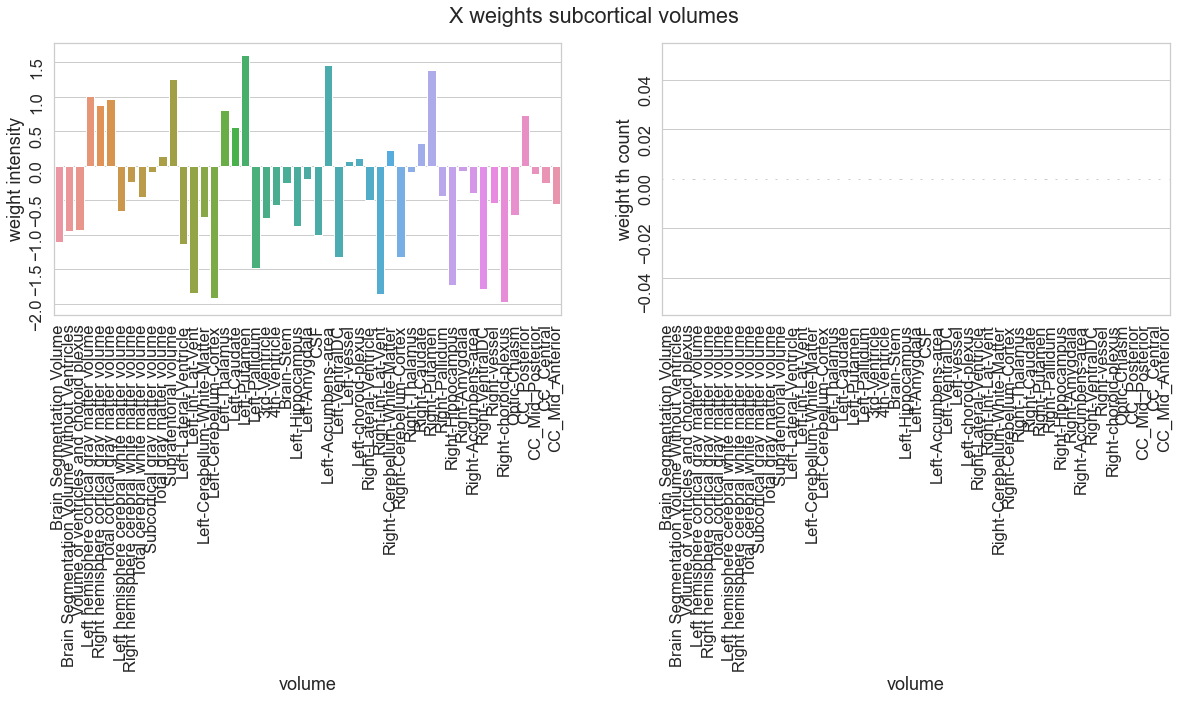

In [61]:
# Gráfico de barras estructuras subcorticales
data = all_data_sorted.iloc[:,3:453]
sch_x_v_weights = pls.bootres.x_weights_normed[:49,icx]
df_x_weights_v = pd.DataFrame(sch_x_v_weights, columns=["weight"])
df_x_weights_v['volume'] = list(data.iloc[:,:49].columns)
th = 3
df_x_weights_v["weight_th"] =  (abs(df_x_weights_v["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,5))
fig.suptitle('X weights subcortical volumes')

g=sns.barplot(x="volume", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=90)
h = sns.barplot(x="volume", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=90)

In [62]:
# Gráfico de barras estructuras corticales
networks7_order = pd.read_csv('data/Schaefer2018_400Parcels_17Networks_order.txt',header=None,delimiter=' ')

sch_x_sch_weights = pls.bootres.x_weights_normed[50:,icx]
df_x_weights_sch = pd.DataFrame(sch_x_sch_weights, columns=["weight"])
df_x_weights_sch.index = networks7_order[1]
df_x_weights_sch["network"] = df_x_weights_sch.index.str.split('_').str.get(2)

df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Default'), 'network'] = 'Default'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('TempPar'), 'network'] = 'Default'

th = 3
df_x_weights_sch["weight_th"] =  (abs(df_x_weights_sch["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes')

order_g = df_x_weights_sch.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], order= order_g,palette=yeo_palett,
            data=df_x_weights_sch)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,order= order_h,palette=yeo_palett,
            data=df_x_weights_sch)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)
# Incluir ROIs en una tabla

ValueError: Length mismatch: Expected axis has 785 elements, new values have 400 elements

In [ ]:
# Gráfico 3D plantilla
schaefer_image = 'data/Schaefer2018_400_17N_MNI152_2mm.nii' 
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th=3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights', symmetric_cmap=False)

In [ ]:
#plotting.view_img_on_surf(values_brain_weight_vol, surf_mesh='fsaverage5', threshold=th, symmetric_cmap=False)

In [ ]:
from nilearn import surface
from nilearn import plotting
from nilearn import datasets


fsaverage = datasets.fetch_surf_fsaverage()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), subplot_kw={'projection': '3d'})

texture1 = surface.vol_to_surf(values_brain_weight_vol, fsaverage.pial_left)
texture2 = surface.vol_to_surf(values_brain_weight_vol, fsaverage.pial_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, texture1, hemi='left', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_left, cmap='magma',
                            axes=ax[0,0],figure = fig, view='medial')

plotting.plot_surf_stat_map(fsaverage.infl_left, texture1, hemi='left', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_left, cmap='magma',
                            axes=ax[0,1],figure = fig, view='lateral')

plotting.plot_surf_stat_map(fsaverage.infl_right, texture2, hemi='right', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_right, cmap='magma',
                            axes=ax[1,0],figure = fig, view='medial')

plotting.plot_surf_stat_map(fsaverage.infl_right, texture2, hemi='right', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_right, cmap='magma',
                            axes=ax[1,1],figure = fig, view='lateral')
plotting.show()

In [ ]:
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
from enigmatoolbox.plotting import plot_surf
from scipy import stats

In [ ]:
def plot_surf(fsaverage, surf_roi=False, cmap='magma', color_bar=True):
    
    col_fsa = parcel_to_surface(sch_x_sch_weights,'schaefer_400_fsa5')
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), subplot_kw={'projection': '3d'})   
    if surf_roi:
        plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=col_fsa[:int(col_fsa.shape[0]/2)],
                           hemi='left', view='medial', colorbar=color_bar,
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5,cmap=cmap, axes=ax[0, 0],figure = fig, threshold=th)
        plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=col_fsa[:int(col_fsa.shape[0]/2)],
                           hemi='left', view='lateral',colorbar=color_bar,
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5,cmap=cmap,axes=ax[0, 1],figure = fig, threshold=th)
        plotting.plot_surf_roi(fsaverage['infl_right'], roi_map=col_fsa[int(col_fsa.shape[0]/2):],
                           hemi='right', view='medial',colorbar=color_bar,
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5,cmap=cmap,axes=ax[1, 0],figure = fig, threshold=th)
        plotting.plot_surf_roi(fsaverage['infl_right'], roi_map=col_fsa[int(col_fsa.shape[0]/2):],
                           hemi='right', view='lateral', colorbar=color_bar,
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5,cmap=cmap,axes=ax[1, 1],figure = fig, threshold=th)     
    else:
        plotting.plot_surf_stat_map(fsaverage['infl_left'], stat_map=col_fsa[:int(col_fsa.shape[0]/2)],
                           hemi='left', view='medial', colorbar=color_bar,
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5,cmap=cmap,axes=ax[0, 0],figure = fig, threshold=th)
        plotting.plot_surf_stat_map(fsaverage['infl_left'], stat_map=col_fsa[:int(col_fsa.shape[0]/2)],
                           hemi='left', view='lateral', colorbar=color_bar,
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5,cmap=cmap,axes=ax[0,1],figure = fig, threshold=th)
        plotting.plot_surf_stat_map(fsaverage['infl_right'], stat_map=col_fsa[int(col_fsa.shape[0]/2):],
                           hemi='right', view='medial', colorbar=color_bar,
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5,cmap=cmap,axes=ax[1, 0],figure = fig, threshold=th)
        plotting.plot_surf_stat_map(fsaverage['infl_right'], stat_map=col_fsa[int(col_fsa.shape[0]/2):],
                           hemi='right', view='lateral', colorbar=color_bar,
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5,cmap=cmap,axes=ax[1,1],figure = fig, threshold=th)

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
plot_surf(fsaverage,cmap='magma',surf_roi=False, color_bar=True)

In [ ]:
col_fsa = parcel_to_surface(sch_x_sch_weights,'schaefer_400_fsa5')
plot_cortical(array_name=col_fsa, surface_name="fsa5", size=(800, 400),
              cmap='magma', color_bar=True, color_range=(-3,3), embed_nb=True)

In [ ]:
# Mapeo personalizado de de Shaefer 7Net con info de colores
coord_schaef= pd.read_csv('data/Schaefer2018_400Parc_17Net_Map_7NetColor.csv')
coord_schaef.set_index('roi_name', inplace= True)
labels_sign = df_x_weights_sch.loc[df_x_weights_sch['weight_th'] == 1].index

adj_mat = np.zeros((len(labels_sign), len(labels_sign)))

coord_schaef= coord_schaef.loc[labels_sign]

node_cmap= np.array(coord_schaef.iloc[:,4:])

plotting.plot_connectome(adj_mat, coord_schaef.iloc[:,1:4], node_color= node_cmap,
                         node_size=100)

## PLS invirtiendo X: behavior, Y: volumes

In [ ]:
# Matriz X: datos de volúmenes
Y = all_data_sorted.iloc[:,3:453].values
X = all_data_sorted[y_list].values

In [ ]:
pls2 = pyls.behavioral_pls(X, Y, groups=list_len, seed=42, n_proc='max')

In [ ]:
pvals2 = pls2.permres['pvals']
x_weights = pls2.bootres.x_weights_normed # 28 
y_weights = pls2.y_weights # 900 (450 características por grupo)
pvals2

In [ ]:
sig_ind = np.where(pvals2 < 0.05)[0]
sig_ind

In [ ]:
pls.varexp[sig_ind]

In [ ]:
conditions2 = all_data_sorted.iloc[:,3:453].columns.to_list()
#conditions2

In [ ]:
conditions = []
for j in conditions2:
    conditions = conditions + [j + '-' + i for i in groups]
#conditions

In [ ]:
# Gráfico que condiciones que no pasan por cero
icx = 0
err = (pls2["bootres"]["y_loadings_ci"][:, icx, 1] - pls2["bootres"]["y_loadings_ci"][:, icx, 0]) / 2   
ind_sig = np.where(abs(err) < abs(pls2["y_loadings"][:, icx]))[0]

color_list = ['C0','C1']

In [ ]:
new_ind = list()
for i in range(len(ind_sig)):
    if ind_sig[i] % 2 == 0: # Si el índice es par
        if i==len(ind_sig)-1:
            new_ind.insert(i+1, ind_sig[i] + 1)
            
        elif ind_sig[i] + 1 == ind_sig[i+1]: # Si los dos índices son consecutivos 
            flag = 'ok'
        else:
            new_ind.insert(i+1, ind_sig[i] + 1) # Insertar consecutivo 
            flag = 'ok'
    else: # Si el índice es impar
        if i==0:
            new_ind.insert(0, ind_sig[i] - 1) # Insertar en la primera posición
            
        elif ind_sig[i] - 1 == ind_sig[i-1]:
            flag = 'ok'
        else:
            new_ind.insert(i-1, ind_sig[i] - 1)
            #print('no')
            
new_sig = list(ind_sig) + new_ind
new_sig.sort()

In [ ]:
# División estructuras subcorticales
sub_idx = np.where(np.array(new_sig) < 100)[0]
sub_sig = np.array(new_sig)[sub_idx.astype(int)]

newfig, axs = plt.subplots(1, 1, figsize=(6,10))

err_sig = (pls2["bootres"]["y_loadings_ci"][sub_sig, icx, 1] - pls2["bootres"]["y_loadings_ci"][sub_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls2["y_loadings"][sub_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i[0:-4] for i in conditions]
labels_sub = np.array(conditions_new)[sub_sig]
labels_sub[1::2] = ' '
axs.set_yticks(np.arange(len(sub_sig)))
axs.set_yticklabels(labels_sub, fontsize = 20)
axs.legend(axx,['ctrl','tab'], fontsize = 20)

In [ ]:
cor_idx = np.where(np.array(new_sig) > 100)[0]
cor_sig = np.array(new_sig)[cor_idx.astype(int)]
newfig, axs = plt.subplots(1, 1, figsize=(6,50))
err_sig = (pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 1] - pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls2["y_loadings"][cor_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i[11:-4] for i in conditions]
labels_cor = np.array(conditions_new)[cor_sig]
labels_cor[1::2] = ' '
axs.set_yticks(np.arange(len(cor_sig)))
axs.set_yticklabels(labels_cor, fontsize = 18)
axs.legend(axx,['ctrl','tab'], fontsize = 18)


In [ ]:
score_pls2 = pd.DataFrame()
score_pls2['subject'] = all_data_sorted['subject']
score_pls2['group'] = all_data_sorted['group']
score_pls2['psy_tavec_re_cl_lp'] = all_data_sorted['psy_tavec_re_cl_lp']
score_pls2['psy_tavec_re_cl_cp'] = all_data_sorted['psy_tavec_re_cl_cp']
score_pls2['x_score']=pls2.x_scores[:,0]
score_pls2['y_score']=pls2.y_scores[:,0]

In [ ]:
# Gráfico x vs y scores con regresión 
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.lmplot(x="x_score", y="y_score", hue="group",data=score_pls2)

plt.title("X SCORE VS Y SCORE LV 1")
plt.show()